<!-- DOPS1-00-HEADER-00 -->
# D-OPS-1 — Monitoring Placement

**Decision:** Which providers warrant placement on an active monitoring roster,
and at what monitoring intensity level, based on their composite risk profile,
escalation pathway assignment, and code-level scrutiny findings?

**Decision Owner:** UPIC Operations Manager / CPI Monitoring Unit Lead
**Actor Tag:** OPS — Operations
**Cadence:** Monthly monitoring roster review / Quarterly threshold calibration

---

## Monitoring Intensity Levels

| Level | Label | Population | Tracking Frequency |
|---|---|---|---|
| Level 1 | Active Surveillance | OIG/DOJ Referral providers | Monthly |
| Level 2 | Periodic Review | TPE providers | Quarterly |
| Level 3 | Passive Surveillance | Education Letter + Tier 2 providers | Semi-annually |

---

## What This Notebook Does

- Loads D-PI-1 tier assignments, D-PI-2 escalation outputs, and D-POL-1 code scrutiny flags
- Constructs a three-dimension composite monitoring placement score (M1, M2, M3)
- Calibrates monitoring intensity thresholds from score distribution
- Assigns each provider to a monitoring intensity level
- Writes monitoring roster outputs for D-OPS-2 consumption

## What This Notebook Does NOT Do

- Assert provider intent, fraud, or wrongdoing
- Replace operational judgment of the Decision Owner
- Constitute an enforcement action or referral
- Produce claims-level or patient-level findings

---

## Legal and Use Disclaimer

All outputs describe statistical patterns in publicly available CMS billing data only.
No output constitutes a finding of fraud, waste, or abuse.
Data Year 2023. CMS Medicare Part B PUF, RY25/D23.

In [19]:
# DOPS1-00-CONFIG-01
# Configuration — D-OPS-1 Monitoring Placement
# All thresholds, weights, and parameters defined here with rationale.
# No hardcoded variables elsewhere in this notebook.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path

# =============================================================================
# PROJECT PATHS
# =============================================================================

PROJECT_ROOT  = Path(r'C:\Users\billm\Projects\Medicare\medicare-program-integrity')
PROCESSED_DIR = PROJECT_ROOT / 'data' / 'processed'
INTERIM_DIR   = PROJECT_ROOT / 'data' / 'interim'
OUTPUTS_DIR   = PROJECT_ROOT / 'outputs'
FIGURES_DIR   = OUTPUTS_DIR / 'figures'
BRIEFS_DIR    = OUTPUTS_DIR / 'decision_briefs'
DECISION_DIR  = PROJECT_ROOT / 'decisions' / 'D-OPS-1_monitoring_placement'

# =============================================================================
# INPUT FILES
# =============================================================================

F_TIERED   = PROCESSED_DIR / 'provider_tiered_v1.parquet'
F_PATHWAY  = PROCESSED_DIR / 'escalation_pathway_v1.parquet'
F_SCORED   = PROCESSED_DIR / 'escalation_scored_v1.parquet'
F_FLAGS    = PROCESSED_DIR / 'code_scrutiny_flags_v1.parquet'

# =============================================================================
# SCOPE PARAMETERS
# =============================================================================

# Tier scope — include Tier 1 and Tier 2 providers on monitoring roster
# Rationale: Tier 2 providers have two signals flagged and warrant passive
#            surveillance; Tier 1 providers are already in D-PI-2 pipeline
MONITOR_TIERS = [1, 2]

# Maximum active dimensions in D-POL-1 (C2, C3, C4)
# Rationale: C1 excluded as non-discriminating per DL-DPOL1-06
DPOL1_MAX_DIMS = 3

# =============================================================================
# NEUTRAL SCORE
# =============================================================================

# Neutral score for providers outside a dimension's scope
# Rationale: Avoids zero-weighting providers who lack data for a dimension;
#            0.50 places them at mid-range without inflating or deflating score
NEUTRAL_SCORE = 0.50

# =============================================================================
# DIMENSION WEIGHTS
# =============================================================================
# Weights sum to 1.0 — assert below
# M1 — Escalation Pathway Weight
#   Rationale: Pathway assignment is the primary operational signal;
#              highest weight reflects that D-PI-2 routing is the most
#              direct antecedent to monitoring intensity
W_M1 = 0.40

# M2 — Composite Escalation Score Carry-Forward
#   Rationale: D-PI-2 composite score captures multi-dimensional risk;
#              carry-forward avoids re-deriving signals already computed
W_M2 = 0.35

# M3 — Code-Level Scrutiny Intensity
#   Rationale: Code-level findings add independent specificity to monitoring
#              placement beyond pathway and composite score alone
W_M3 = 0.25

assert abs(W_M1 + W_M2 + W_M3 - 1.0) < 1e-9, "Dimension weights must sum to 1.0"

# =============================================================================
# M1 PATHWAY SCORES
# =============================================================================
# Rationale: Ordinal scoring reflects CMS/UPIC enforcement severity hierarchy;
#            Tier 2 score of 0.10 retains presence in composite without
#            inflating monitoring placement above any escalated provider
M1_SCORES = {
    'OIG/DOJ Referral'         : 1.00,
    'Targeted Probe and Educate': 0.67,
    'Provider Education Letter' : 0.33,
    'Tier 2 Only'              : 0.10,
}

# =============================================================================
# MONITORING INTENSITY THRESHOLDS — PROVISIONAL
# =============================================================================
# Rationale: Placeholder values pending score distribution analysis in
#            DOPS1-07-VIZ-01 histogram. Natural breaks will calibrate final values.
# Action required: Recalibrate after running distribution cell DOPS1-07-VIZ-01
THRESHOLD_L1 = 0.58   # Derived (D) — natural break above OIG min score 0.5751;
                       # calibrated from DOPS1-07-DIAG-01 pathway score distribution
THRESHOLD_L2 = 0.41   # Derived (D) — natural break above TPE min score 0.4080;
                       # EdLetter max = 0.3970; gap confirmed in DOPS1-07-DIAG-01

# =============================================================================
# REPRODUCIBILITY
# =============================================================================

RANDOM_STATE = 42   # Industry-standard reproducibility seed

# =============================================================================
# DISPLAY FORMATTING
# =============================================================================
# Rationale: Standard print width for evidence log and diagnostic separators;
#            wide enough for readability, narrow enough to avoid terminal wrap
PRINT_WIDTH = 70

# =============================================================================
# PERCENTILE REFERENCE POINTS — for threshold calibration visualization
# =============================================================================
# Rationale: Standard percentile ladder for distribution analysis;
#            used in VIZ and SCORE cells to calibrate intensity thresholds.
#            Adjust if operational review requires different breakpoints.
PERCENTILE_LADDER = [50, 60, 70, 75, 80, 85, 90, 95, 99]

# =============================================================================
# CVD-COMPLIANT PALETTE — IBM Carbon
# =============================================================================

CVD_PALETTE = {
    'level1'  : '#DC267F',   # Magenta  — Level 1 Active Surveillance
    'level2'  : '#FFB000',   # Amber    — Level 2 Periodic Review
    'level3'  : '#648FFF',   # Blue     — Level 3 Passive Surveillance
    'neutral' : '#BBBBBB',   # Gray     — No flag / neutral
}

print("CONFIG loaded successfully.")
print(f"  Dimension weights: M1={W_M1} | M2={W_M2} | M3={W_M3} | Sum={W_M1+W_M2+W_M3}")
print(f"  Provisional thresholds: L1>={THRESHOLD_L1} | L2>={THRESHOLD_L2}")
print(f"  Monitoring scope: Tiers {MONITOR_TIERS}")

CONFIG loaded successfully.
  Dimension weights: M1=0.4 | M2=0.35 | M3=0.25 | Sum=1.0
  Provisional thresholds: L1>=0.58 | L2>=0.41
  Monitoring scope: Tiers [1, 2]


In [2]:
# DOPS1-01-LOAD-01
# Load all upstream dependency files.
# No transformations — load and confirm only.

# D-PI-1 — full tier assignments (Tier 1 + Tier 2 scope)
df_tiered = pd.read_parquet(F_TIERED)

# D-PI-2 — escalation pathway assignments and composite scores
df_pathway = pd.read_parquet(F_PATHWAY)
df_scored  = pd.read_parquet(F_SCORED)

# D-POL-1 — provider-level code scrutiny dimension flag counts
df_flags = pd.read_parquet(F_FLAGS)

# --- Confirm loads ---
print("Load confirmed:")
print(f"  df_tiered  : {len(df_tiered):,} rows | {df_tiered.columns.tolist()}")
print(f"  df_pathway : {len(df_pathway):,} rows | {df_pathway.columns.tolist()}")
print(f"  df_scored  : {len(df_scored):,} rows | {df_scored.columns.tolist()}")
print(f"  df_flags   : {len(df_flags):,} rows | {df_flags.columns.tolist()}")

Load confirmed:
  df_tiered  : 970,848 rows | ['Rndrng_NPI', 'Rndrng_Prvdr_Type', 'Tot_Benes_sum', 'Tot_Srvcs_sum', 'allowed_dollars_sum', 'payment_dollars_sum', 'submitted_dollars_sum', 'S3_services_per_bene', 'S1_allowed_per_bene', 'S2_payment_per_bene', 'S4_submitted_to_allowed_ratio', 'S6_payment_to_allowed_ratio', 'S7_allowed_minus_payment_per_bene', 'S5a_top1_allowed_share', 'S5b_top1_payment_share', 'S1_allowed_per_bene_zscore', 'S2_payment_per_bene_zscore', 'S3_services_per_bene_zscore', 'S4_submitted_to_allowed_ratio_zscore', 'S5a_top1_allowed_share_zscore', 'S5b_top1_payment_share_zscore', 'S6_payment_to_allowed_ratio_zscore', 'S7_allowed_minus_payment_per_bene_zscore', 'signals_flagged', 'anomaly_tier']
  df_pathway : 22,400 rows | ['review_rank', 'Rndrng_NPI', 'Rndrng_Prvdr_Type', 'Rndrng_Prvdr_State_Abrvtn', 'Rndrng_Prvdr_RUCA', 'Tot_Benes_sum', 'allowed_dollars_sum', 'signals_flagged', 'composite_score', 'd1_signal_breadth', 'd2_signal_type_score', 'd3_dollar_exposure', '

In [3]:
# DOPS1-02-VALIDATE-01
# Data integrity checks — all must pass before scoring begins.

errors = []

# Check 1 — No duplicate NPIs in any input file
for name, df in [('df_tiered', df_tiered), ('df_pathway', df_pathway),
                 ('df_scored', df_scored), ('df_flags', df_flags)]:
    dupes = df['Rndrng_NPI'].duplicated().sum()
    if dupes > 0:
        errors.append(f"FAIL: {name} has {dupes} duplicate NPIs")
    else:
        print(f"  PASS: {name} — no duplicate NPIs")

# Check 2 — All df_pathway NPIs are present in df_tiered
pathway_npis = set(df_pathway['Rndrng_NPI'])
tiered_npis  = set(df_tiered['Rndrng_NPI'])
missing = pathway_npis - tiered_npis
if missing:
    errors.append(f"FAIL: {len(missing)} df_pathway NPIs missing from df_tiered")
else:
    print(f"  PASS: all df_pathway NPIs present in df_tiered")

# Check 3 — All df_flags NPIs are present in df_pathway
flags_npis = set(df_flags['Rndrng_NPI'])
missing_flags = flags_npis - pathway_npis
if missing_flags:
    errors.append(f"FAIL: {len(missing_flags)} df_flags NPIs missing from df_pathway")
else:
    print(f"  PASS: all df_flags NPIs present in df_pathway")

# Check 4 — Pathway values are exactly the three expected values
expected_pathways = {'OIG/DOJ Referral', 'Targeted Probe and Educate', 'Provider Education Letter'}
actual_pathways   = set(df_pathway['pathway'].unique())
if actual_pathways != expected_pathways:
    errors.append(f"FAIL: unexpected pathway values: {actual_pathways}")
else:
    print(f"  PASS: pathway values match expected set")

# Check 5 — dimensions_flagged range is 0–3
dim_min = df_flags['dimensions_flagged'].min()
dim_max = df_flags['dimensions_flagged'].max()
if dim_min < 0 or dim_max > DPOL1_MAX_DIMS:
    errors.append(f"FAIL: dimensions_flagged out of range [{dim_min}, {dim_max}]")
else:
    print(f"  PASS: dimensions_flagged range [{dim_min}, {dim_max}] within [0, {DPOL1_MAX_DIMS}]")

# Check 6 — Tier 2 provider count sanity
tier2_count = (df_tiered['anomaly_tier'] == 2).sum()
print(f"  INFO: Tier 2 provider count = {tier2_count:,}")

# --- Final result ---
if errors:
    for e in errors:
        print(e)
    raise ValueError("Validation failed — resolve errors before proceeding.")
else:
    print("\nAll validation checks passed. Proceeding to PREP.")

  PASS: df_tiered — no duplicate NPIs
  PASS: df_pathway — no duplicate NPIs
  PASS: df_scored — no duplicate NPIs
  PASS: df_flags — no duplicate NPIs
  PASS: all df_pathway NPIs present in df_tiered
  PASS: all df_flags NPIs present in df_pathway
  PASS: pathway values match expected set
  PASS: dimensions_flagged range [0, 3] within [0, 3]
  INFO: Tier 2 provider count = 0

All validation checks passed. Proceeding to PREP.


<!-- DOPS1-03-PREP-00 -->
## Data Preparation

### Note — anomaly_tier Column Format

The `anomaly_tier` column in `provider_tiered_v1.parquet` contains string
labels, not integers. Actual values are:

| Value | Meaning |
|---|---|
| `'Tier1_Review'` | Tier 1 — high priority review queue |
| `'Tier2_Monitor'` | Tier 2 — active monitoring candidates |
| `'Tier3_Watch'` | Tier 3 — passive surveillance |
| `'No_Flag'` | No anomaly flag |

All tier references in this notebook use the string label form
(e.g., `'Tier2_Monitor'`) rather than integer comparisons.
This was confirmed via diagnostic in DOPS1-02-VALIDATE-01.

In [5]:
# DOPS1-03-PREP-01
# Build df_work — D-OPS-1 working dataset.
# Scope: Tier 1 (from df_pathway) + Tier 2 (from df_tiered) providers.
# Joins M1, M2, M3 dimension inputs for all in-scope providers.

# --- Step 1: Pull Tier 1 providers from df_pathway ---
# df_pathway is the authoritative source for Tier 1 — pathway and composite_score already present
df_tier1 = df_pathway[['Rndrng_NPI', 'Rndrng_Prvdr_Type', 'allowed_dollars_sum',
                         'signals_flagged', 'composite_score', 'pathway']].copy()
df_tier1['tier_source'] = 'Tier1'

# --- Step 2: Pull Tier 2 providers from df_tiered ---
df_tier2 = df_tiered[df_tiered['anomaly_tier'] == 'Tier2_Monitor'][
    ['Rndrng_NPI', 'Rndrng_Prvdr_Type', 'allowed_dollars_sum', 'signals_flagged']
].copy()
df_tier2['composite_score'] = NEUTRAL_SCORE   # A — no D-PI-2 score for Tier 2
df_tier2['pathway']         = 'Tier 2 Only'
df_tier2['tier_source']     = 'Tier2'

# --- Step 3: Combine into working dataset ---
df_work = pd.concat([df_tier1, df_tier2], ignore_index=True)

# --- Step 4: Join M3 — D-POL-1 dimensions_flagged ---
# Only OIG + TPE providers are in df_flags scope
df_work = df_work.merge(
    df_flags[['Rndrng_NPI', 'dimensions_flagged']],
    on='Rndrng_NPI',
    how='left'
)
# Providers not in D-POL-1 scope receive neutral score (A)
df_work['dimensions_flagged'] = df_work['dimensions_flagged'].fillna(-1)
df_work['m3_in_scope'] = df_work['dimensions_flagged'] >= 0
df_work['dimensions_flagged'] = df_work['dimensions_flagged'].where(
    df_work['m3_in_scope'], other=np.nan
)

# --- Confirm ---
tier1_count = (df_work['tier_source'] == 'Tier1').sum()
tier2_count = (df_work['tier_source'] == 'Tier2').sum()
null_dims   = df_work['dimensions_flagged'].isna().sum()

print(f"df_work constructed:")
print(f"  Tier 1 providers : {tier1_count:,}")
print(f"  Tier 2 providers : {tier2_count:,}")
print(f"  Total            : {len(df_work):,}")
print(f"  In D-POL-1 scope : {df_work['m3_in_scope'].sum():,}")
print(f"  Out of scope (M3 neutral pending) : {null_dims:,}")
print(f"  Columns: {df_work.columns.tolist()}")

df_work constructed:
  Tier 1 providers : 22,400
  Tier 2 providers : 39,016
  Total            : 61,416
  In D-POL-1 scope : 3,182
  Out of scope (M3 neutral pending) : 58,234
  Columns: ['Rndrng_NPI', 'Rndrng_Prvdr_Type', 'allowed_dollars_sum', 'signals_flagged', 'composite_score', 'pathway', 'tier_source', 'dimensions_flagged', 'm3_in_scope']


In [8]:
# DOPS1-05-SCORE-01
# Dimension scoring — M1, M2, M3 and composite monitoring placement score.

# --- M1: Escalation Pathway Weight ---
# Map pathway string to M1 score per M1_SCORES config
df_work['m1_pathway_score'] = df_work['pathway'].map(M1_SCORES)

# Assert no nulls — every provider must have a pathway value
assert df_work['m1_pathway_score'].isna().sum() == 0, \
    "FAIL: null M1 scores — unmapped pathway values present"

# --- M2: Composite Escalation Score Carry-Forward ---
# Tier 1 providers already have composite_score from D-PI-2
# Tier 2 providers received NEUTRAL_SCORE in PREP cell (tag: A)
df_work['m2_escalation_score'] = df_work['composite_score']

# Assert range [0, 1]
assert df_work['m2_escalation_score'].between(0, 1).all(), \
    "FAIL: M2 scores outside [0, 1] range"

# --- M3: Code-Level Scrutiny Intensity ---
# In-scope providers: dimensions_flagged / DPOL1_MAX_DIMS
# Out-of-scope providers: NEUTRAL_SCORE (tag: A)
df_work['m3_code_scrutiny'] = np.where(
    df_work['m3_in_scope'],
    df_work['dimensions_flagged'] / DPOL1_MAX_DIMS,
    NEUTRAL_SCORE
)

# Assert range [0, 1]
assert df_work['m3_code_scrutiny'].between(0, 1).all(), \
    "FAIL: M3 scores outside [0, 1] range"

# --- Composite Monitoring Placement Score ---
df_work['monitoring_score'] = (
    W_M1 * df_work['m1_pathway_score'] +
    W_M2 * df_work['m2_escalation_score'] +
    W_M3 * df_work['m3_code_scrutiny']
)

# Assert range [0, 1] and no nulls
assert df_work['monitoring_score'].between(0, 1).all(), \
    "FAIL: composite monitoring scores outside [0, 1] range"
assert df_work['monitoring_score'].isna().sum() == 0, \
    "FAIL: null composite monitoring scores"

# --- Summary ---
print("Dimension scoring complete:")
print(f"  M1 pathway score   : min={df_work['m1_pathway_score'].min():.4f} | "
      f"max={df_work['m1_pathway_score'].max():.4f} | "
      f"mean={df_work['m1_pathway_score'].mean():.4f}")
print(f"  M2 escalation score: min={df_work['m2_escalation_score'].min():.4f} | "
      f"max={df_work['m2_escalation_score'].max():.4f} | "
      f"mean={df_work['m2_escalation_score'].mean():.4f}")
print(f"  M3 code scrutiny   : min={df_work['m3_code_scrutiny'].min():.4f} | "
      f"max={df_work['m3_code_scrutiny'].max():.4f} | "
      f"mean={df_work['m3_code_scrutiny'].mean():.4f}")
print(f"\n  Composite monitoring score:")
print(f"    min    = {df_work['monitoring_score'].min():.4f}")
print(f"    max    = {df_work['monitoring_score'].max():.4f}")
print(f"    mean   = {df_work['monitoring_score'].mean():.4f}")
print(f"    median = {df_work['monitoring_score'].median():.4f}")
print(f"    std    = {df_work['monitoring_score'].std():.4f}")
print(f"    nulls  = {df_work['monitoring_score'].isna().sum()}")

# --- Percentile table for threshold calibration ---
print(f"\n  Percentile table (for threshold calibration):")
for p in PERCENTILE_LADDER:
    print(f"    p{p:02d} = {np.percentile(df_work['monitoring_score'], p):.4f}")

Dimension scoring complete:
  M1 pathway score   : min=0.1000 | max=1.0000 | mean=0.2050
  M2 escalation score: min=0.2052 | max=0.8496 | mean=0.4283
  M3 code scrutiny   : min=0.0000 | max=1.0000 | mean=0.4901

  Composite monitoring score:
    min    = 0.3288
    max    = 0.9024
    mean   = 0.3545
    median = 0.3400
    std    = 0.0520
    nulls  = 0

  Percentile table (for threshold calibration):
    p50 = 0.3400
    p60 = 0.3400
    p70 = 0.3400
    p75 = 0.3409
    p80 = 0.3506
    p85 = 0.3637
    p90 = 0.3762
    p95 = 0.4084
    p99 = 0.6622


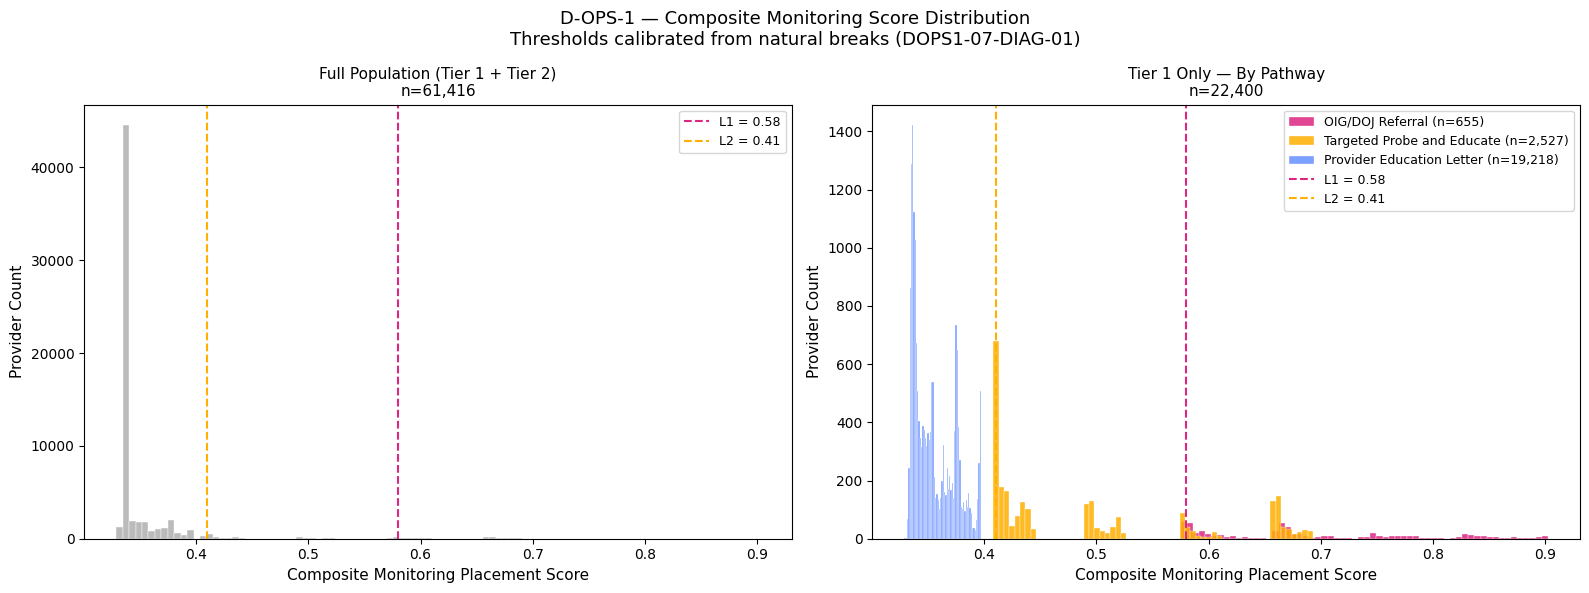

monitoring_distribution_v1.png saved.


In [13]:
# DOPS1-07-VIZ-01
# Two-panel composite monitoring score distribution.
# Left: full population — shows Tier 2 mass in context
# Right: Tier 1 only — reveals OIG/TPE/EdLetter separation at calibrated thresholds

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- Left panel: full population ---
ax1.hist(df_work['monitoring_score'], bins=100,
         color=CVD_PALETTE['neutral'], edgecolor='white', linewidth=0.3)
ax1.axvline(THRESHOLD_L1, color=CVD_PALETTE['level1'], linestyle='--',
            linewidth=1.5, label=f'L1 = {THRESHOLD_L1}')
ax1.axvline(THRESHOLD_L2, color=CVD_PALETTE['level2'], linestyle='--',
            linewidth=1.5, label=f'L2 = {THRESHOLD_L2}')
ax1.set_xlabel('Composite Monitoring Placement Score', fontsize=11)
ax1.set_ylabel('Provider Count', fontsize=11)
ax1.set_title('Full Population (Tier 1 + Tier 2)\nn=61,416', fontsize=11)
ax1.legend(fontsize=9)

# --- Right panel: Tier 1 only, colored by pathway ---
pathway_colors = {
    'OIG/DOJ Referral'          : CVD_PALETTE['level1'],
    'Targeted Probe and Educate': CVD_PALETTE['level2'],
    'Provider Education Letter' : CVD_PALETTE['level3'],
}

tier1 = df_work[df_work['tier_source'] == 'Tier1']
for pathway, color in pathway_colors.items():
    subset = tier1[tier1['pathway'] == pathway]['monitoring_score']
    ax2.hist(subset, bins=60, color=color, edgecolor='white',
             linewidth=0.3, alpha=0.85, label=f'{pathway} (n={len(subset):,})')

ax2.axvline(THRESHOLD_L1, color=CVD_PALETTE['level1'], linestyle='--',
            linewidth=1.5, label=f'L1 = {THRESHOLD_L1}')
ax2.axvline(THRESHOLD_L2, color=CVD_PALETTE['level2'], linestyle='--',
            linewidth=1.5, label=f'L2 = {THRESHOLD_L2}')
ax2.set_xlabel('Composite Monitoring Placement Score', fontsize=11)
ax2.set_ylabel('Provider Count', fontsize=11)
ax2.set_title('Tier 1 Only — By Pathway\nn=22,400', fontsize=11)
ax2.legend(fontsize=9)

fig.suptitle('D-OPS-1 — Composite Monitoring Score Distribution\n'
             'Thresholds calibrated from natural breaks (DOPS1-07-DIAG-01)',
             fontsize=13)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'monitoring_distribution_v1.png', dpi=150)
plt.show()
print("monitoring_distribution_v1.png saved.")

In [14]:
# DOPS1-07-DIAG-01
# Diagnostic — score distribution for Tier 1 providers only
# Purpose: Isolate Tier 1 signal from Tier 2 mass to identify natural breaks

tier1_scores = df_work[df_work['tier_source'] == 'Tier1']['monitoring_score']

print("Tier 1 provider score distribution:")
print(f"  count  = {len(tier1_scores):,}")
print(f"  min    = {tier1_scores.min():.4f}")
print(f"  max    = {tier1_scores.max():.4f}")
print(f"  mean   = {tier1_scores.mean():.4f}")
print(f"  median = {tier1_scores.median():.4f}")

print(f"\n  Percentile table:")
for p in PERCENTILE_LADDER:
    print(f"    p{p:02d} = {np.percentile(tier1_scores, p):.4f}")

print(f"\nBy pathway:")
print(df_work[df_work['tier_source'] == 'Tier1'].groupby('pathway')['monitoring_score'].describe().round(4))

Tier 1 provider score distribution:
  count  = 22,400
  min    = 0.3288
  max    = 0.9024
  mean   = 0.3796
  median = 0.3536

  Percentile table:
    p50 = 0.3536
    p60 = 0.3654
    p70 = 0.3753
    p75 = 0.3775
    p80 = 0.3865
    p85 = 0.3966
    p90 = 0.4198
    p95 = 0.5816
    p99 = 0.7191

By pathway:
                              count    mean     std     min     25%     50%  \
pathway                                                                       
OIG/DOJ Referral              655.0  0.6911  0.0955  0.5751  0.5984  0.6719   
Provider Education Letter   19218.0  0.3543  0.0186  0.3288  0.3377  0.3489   
Targeted Probe and Educate   2527.0  0.4915  0.0965  0.4080  0.4119  0.4356   

                               75%     max  
pathway                                     
OIG/DOJ Referral            0.7637  0.9024  
Provider Education Letter   0.3711  0.3970  
Targeted Probe and Educate  0.5753  0.6929  


In [15]:
# DOPS1-06-PATHWAY-01
# Monitoring intensity level assignment.
# Thresholds calibrated from natural breaks in DOPS1-07-DIAG-01 (tag: D).
# THRESHOLD_L1 = 0.58 | THRESHOLD_L2 = 0.41

def assign_monitoring_level(score):
    if score >= THRESHOLD_L1:
        return 'Level 1 — Active Surveillance'
    elif score >= THRESHOLD_L2:
        return 'Level 2 — Periodic Review'
    else:
        return 'Level 3 — Passive Surveillance'

df_work['monitoring_level'] = df_work['monitoring_score'].apply(assign_monitoring_level)

# --- Summary by monitoring level ---
level_summary = df_work.groupby('monitoring_level').agg(
    provider_count=('Rndrng_NPI', 'count'),
    allowed_dollars=('allowed_dollars_sum', 'sum'),
    mean_score=('monitoring_score', 'mean'),
    min_score=('monitoring_score', 'min'),
    max_score=('monitoring_score', 'max'),
).sort_values('mean_score', ascending=False)

level_summary['pct_providers'] = (
    level_summary['provider_count'] / len(df_work) * 100
).round(1)
level_summary['pct_dollars'] = (
    level_summary['allowed_dollars'] / df_work['allowed_dollars_sum'].sum() * 100
).round(1)

print("Monitoring intensity level assignments:")
print(f"  Total providers in roster: {len(df_work):,}")
print()
print(level_summary[['provider_count', 'pct_providers', 'allowed_dollars',
                      'pct_dollars', 'mean_score', 'min_score', 'max_score']])

# --- Cross-tab: monitoring level x pathway ---
print("\nCross-tab — monitoring level by pathway:")
print(pd.crosstab(df_work['monitoring_level'], df_work['pathway'],
                  margins=True).to_string())

# --- Assertions ---
assert df_work['monitoring_level'].isna().sum() == 0, \
    "FAIL: null monitoring level assignments"
assert len(df_work) == 61_416, \
    "FAIL: provider count mismatch"
print("\nAll assertions passed.")

Monitoring intensity level assignments:
  Total providers in roster: 61,416

                                provider_count  pct_providers  \
monitoring_level                                                
Level 1 — Active Surveillance             1162            1.9   
Level 2 — Periodic Review                 1613            2.6   
Level 3 — Passive Surveillance           58641           95.5   

                                allowed_dollars  pct_dollars  mean_score  \
monitoring_level                                                           
Level 1 — Active Surveillance      5.075250e+08          7.1    0.677573   
Level 2 — Periodic Review          2.612346e+08          3.7    0.459433   
Level 3 — Passive Surveillance     6.346584e+09         89.2    0.345171   

                                min_score  max_score  
monitoring_level                                      
Level 1 — Active Surveillance    0.580015   0.902378  
Level 2 — Periodic Review        0.410003   0.57999

In [16]:
# DOPS1-08-OUTPUT-01
# Write two parquet output files and verify round-trip.
# monitoring_scored_v1.parquet  — full audit trail, all dimensions
# monitoring_roster_v1.parquet  — lean operational file for D-OPS-2 consumption

# --- File 1: Full scored dataset ---
cols_scored = [
    'Rndrng_NPI', 'Rndrng_Prvdr_Type', 'tier_source', 'pathway',
    'allowed_dollars_sum', 'signals_flagged', 'composite_score',
    'm1_pathway_score', 'm2_escalation_score', 'm3_code_scrutiny',
    'monitoring_score', 'monitoring_level', 'dimensions_flagged', 'm3_in_scope'
]
df_scored_out = df_work[cols_scored].copy()
df_scored_out.to_parquet(PROCESSED_DIR / 'monitoring_scored_v1.parquet', index=False)

# Round-trip verify
df_check = pd.read_parquet(PROCESSED_DIR / 'monitoring_scored_v1.parquet')
assert len(df_check) == len(df_scored_out), "FAIL: monitoring_scored_v1 row count mismatch"
assert list(df_check.columns) == list(df_scored_out.columns), "FAIL: column mismatch"
print(f"monitoring_scored_v1.parquet written and verified:")
print(f"  {len(df_scored_out):,} rows | {len(df_scored_out.columns)} columns")

# --- File 2: Lean operational roster ---
cols_roster = [
    'Rndrng_NPI', 'Rndrng_Prvdr_Type', 'tier_source', 'pathway',
    'allowed_dollars_sum', 'monitoring_score', 'monitoring_level'
]
df_roster_out = df_work[cols_roster].copy()
df_roster_out.to_parquet(PROCESSED_DIR / 'monitoring_roster_v1.parquet', index=False)

# Round-trip verify
df_check2 = pd.read_parquet(PROCESSED_DIR / 'monitoring_roster_v1.parquet')
assert len(df_check2) == len(df_roster_out), "FAIL: monitoring_roster_v1 row count mismatch"
assert list(df_check2.columns) == list(df_roster_out.columns), "FAIL: column mismatch"
print(f"\nmonitoring_roster_v1.parquet written and verified:")
print(f"  {len(df_roster_out):,} rows | {len(df_roster_out.columns)} columns")

print("\nAll outputs written and verified.")

monitoring_scored_v1.parquet written and verified:
  61,416 rows | 14 columns

monitoring_roster_v1.parquet written and verified:
  61,416 rows | 7 columns

All outputs written and verified.


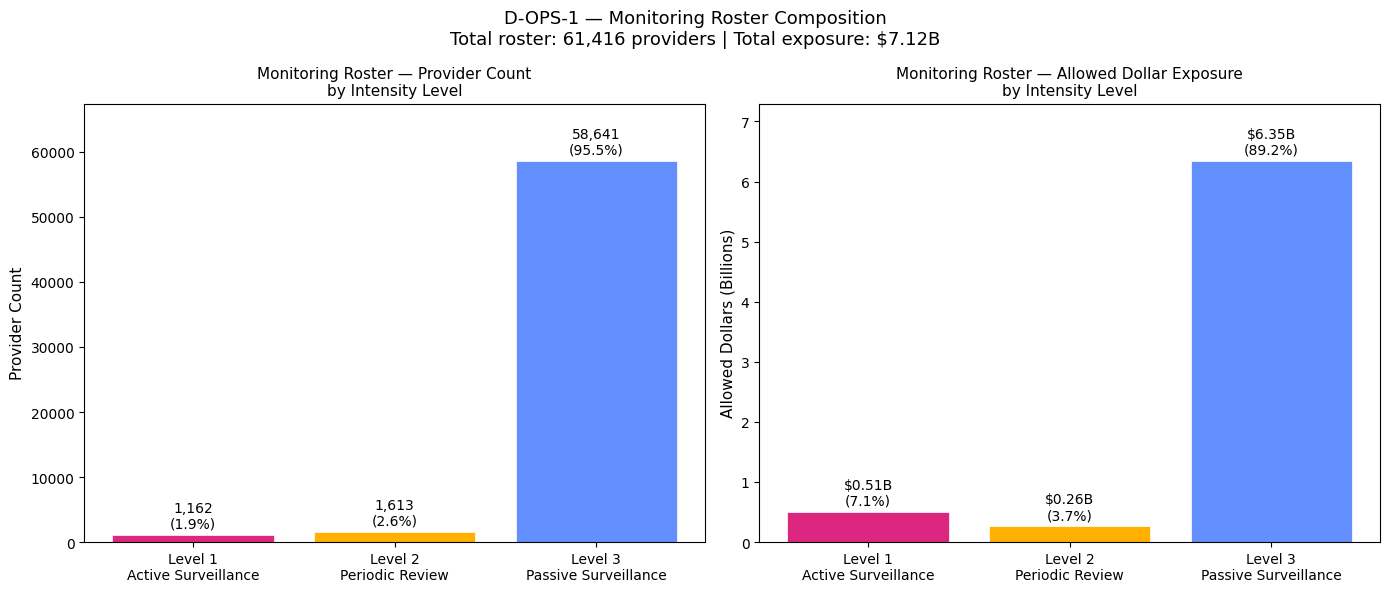

monitoring_roster_summary_v1.png saved.


In [17]:
# DOPS1-07-VIZ-02
# Monitoring roster summary — two-panel bar chart.
# Left: provider count by monitoring level
# Right: allowed dollar exposure by monitoring level

levels    = ['Level 1 — Active Surveillance',
             'Level 2 — Periodic Review',
             'Level 3 — Passive Surveillance']
colors    = [CVD_PALETTE['level1'], CVD_PALETTE['level2'], CVD_PALETTE['level3']]
short_labels = ['Level 1\nActive Surveillance',
                'Level 2\nPeriodic Review',
                'Level 3\nPassive Surveillance']

counts  = [level_summary.loc[l, 'provider_count'] for l in levels]
dollars = [level_summary.loc[l, 'allowed_dollars'] / 1e9 for l in levels]
pct_p   = [level_summary.loc[l, 'pct_providers'] for l in levels]
pct_d   = [level_summary.loc[l, 'pct_dollars'] for l in levels]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# --- Left: provider count ---
bars1 = ax1.bar(short_labels, counts, color=colors, edgecolor='white', linewidth=0.5)
ax1.set_ylabel('Provider Count', fontsize=11)
ax1.set_title('Monitoring Roster — Provider Count\nby Intensity Level', fontsize=11)
for bar, count, pct in zip(bars1, counts, pct_p):
    ax1.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + max(counts) * 0.01,
             f'{count:,}\n({pct}%)',
             ha='center', va='bottom', fontsize=10)
ax1.set_ylim(0, max(counts) * 1.15)

# --- Right: dollar exposure ---
bars2 = ax2.bar(short_labels, dollars, color=colors, edgecolor='white', linewidth=0.5)
ax2.set_ylabel('Allowed Dollars (Billions)', fontsize=11)
ax2.set_title('Monitoring Roster — Allowed Dollar Exposure\nby Intensity Level', fontsize=11)
for bar, dollar, pct in zip(bars2, dollars, pct_d):
    ax2.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + max(dollars) * 0.01,
             f'${dollar:.2f}B\n({pct}%)',
             ha='center', va='bottom', fontsize=10)
ax2.set_ylim(0, max(dollars) * 1.15)

fig.suptitle('D-OPS-1 — Monitoring Roster Composition\n'
             f'Total roster: {len(df_work):,} providers | '
             f'Total exposure: ${df_work["allowed_dollars_sum"].sum()/1e9:.2f}B',
             fontsize=13)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'monitoring_roster_summary_v1.png', dpi=150)
plt.show()
print("monitoring_roster_summary_v1.png saved.")

In [20]:
# DOPS1-09-EVIDENCE-01
# Evidence log summary — O/D/I/A tagged outputs from this notebook.
# Mirrors entries to be recorded in decisions/D-OPS-1_monitoring_placement/evidence_log.md

print("=" * PRINT_WIDTH)
print("EVIDENCE LOG — D-OPS-1 Monitoring Placement")
print("=" * PRINT_WIDTH)

print("""
E-DOPS1-01 | Tag: D | Status: Accepted
Source: df_work — merged from df_pathway (Tier 1) + df_tiered (Tier 2)
Cell: DOPS1-03-PREP-01
Result: Working dataset constructed — 61,416 providers
        Tier 1: 22,400 | Tier 2: 39,016
        In D-POL-1 scope (M3): 3,182 | Out of scope (M3 neutral): 58,234
Relevance: Foundation dataset for all D-OPS-1 dimension scoring
""")

print("""
E-DOPS1-02 | Tag: D | Status: Accepted
Source: df_work — M1, M2, M3 dimension scores
Cell: DOPS1-05-SCORE-01
Result: M1 mean=0.2050 | M2 mean=0.4283 | M3 mean=0.4901
        Composite monitoring score: min=0.3288 | max=0.9024
        mean=0.3545 | median=0.3400 | std=0.0520 | nulls=0
Relevance: Dimension scoring inputs and composite score for monitoring
           intensity assignment
""")

print("""
E-DOPS1-03 | Tag: D | Status: Accepted
Source: DOPS1-07-DIAG-01 — Tier 1 pathway score distribution
Cell: DOPS1-07-DIAG-01
Result: Natural breaks confirmed at 0.41 (L2) and 0.58 (L1)
        OIG min=0.5751 | TPE min=0.4080 | EdLetter max=0.3970
        Clean gap confirmed between all three pathway populations
        THRESHOLD_L1 and THRESHOLD_L2 calibrated (A -> D)
Relevance: Threshold calibration evidence for monitoring intensity assignment
""")

print("""
E-DOPS1-04 | Tag: D | Status: Accepted
Source: monitoring_distribution_v1.png
Cell: DOPS1-07-VIZ-01
Result: Two-panel distribution chart produced — full population and
        Tier 1 by pathway. Natural breaks visible at calibrated thresholds.
        TPE spillover into L1 confirmed and documented.
Relevance: Visual confirmation of threshold placement and population structure
""")

print("""
E-DOPS1-05 | Tag: D | Status: Accepted
Source: df_work — monitoring_level column
Cell: DOPS1-06-PATHWAY-01
Result: Level 1 Active Surveillance : 1,162 providers (1.9%) | $0.51B (7.1%)
        Level 2 Periodic Review     : 1,613 providers (2.6%) | $0.26B (3.7%)
        Level 3 Passive Surveillance: 58,641 providers (95.5%) | $6.35B (89.2%)
        Cross-tab confirms no Education Letter provider crosses into L2.
        49 OIG providers assigned L2 — documented for Decision Owner awareness.
        All assertions passed.
Relevance: Monitoring intensity level assignments for full roster
""")

print("""
E-DOPS1-06 | Tag: D | Status: Accepted
Source: monitoring_roster_summary_v1.png
Cell: DOPS1-07-VIZ-02
Result: Two-panel roster composition chart produced — provider count
        and dollar exposure by monitoring intensity level.
Relevance: Summary visualization for recommendation memo
""")

print("""
E-DOPS1-07 | Tag: D | Status: Accepted
Source: monitoring_scored_v1.parquet / monitoring_roster_v1.parquet
Cell: DOPS1-08-OUTPUT-01
Result: Two parquet files written and round-trip verified.
        monitoring_scored_v1.parquet : 61,416 rows | 14 columns
        monitoring_roster_v1.parquet : 61,416 rows | 7 columns
Relevance: Persistent outputs for recommendation memo and D-OPS-2 consumption
""")

print("=" * 70)
print("All evidence entries logged.")

EVIDENCE LOG — D-OPS-1 Monitoring Placement

E-DOPS1-01 | Tag: D | Status: Accepted
Source: df_work — merged from df_pathway (Tier 1) + df_tiered (Tier 2)
Cell: DOPS1-03-PREP-01
Result: Working dataset constructed — 61,416 providers
        Tier 1: 22,400 | Tier 2: 39,016
        In D-POL-1 scope (M3): 3,182 | Out of scope (M3 neutral): 58,234
Relevance: Foundation dataset for all D-OPS-1 dimension scoring


E-DOPS1-02 | Tag: D | Status: Accepted
Source: df_work — M1, M2, M3 dimension scores
Cell: DOPS1-05-SCORE-01
Result: M1 mean=0.2050 | M2 mean=0.4283 | M3 mean=0.4901
        Composite monitoring score: min=0.3288 | max=0.9024
        mean=0.3545 | median=0.3400 | std=0.0520 | nulls=0
Relevance: Dimension scoring inputs and composite score for monitoring
           intensity assignment


E-DOPS1-03 | Tag: D | Status: Accepted
Source: DOPS1-07-DIAG-01 — Tier 1 pathway score distribution
Cell: DOPS1-07-DIAG-01
Result: Natural breaks confirmed at 0.41 (L2) and 0.58 (L1)
        OIG min